# How Multi-Task Road Extractor works?

### Introduction

In the guide [How u-net works](https://developers.arcgis.com/python/guide/how-unet-works/), we have learned in detail about semantic segmentation using U-net in the ArcGIS API for Python. There are many other semantic segmentation algorithms like PSPNet, Deeplab, etc which can perform road extraction. However, road network extraction from satellite images often produce fragmented road segments using only semantic segmentation algorithms, as satellite images pose difficulties in the extraction of roads due to (a) shadows of clouds and trees, (b) diverse appearance and illumination condition due to terrain, weather, geography, etc., and, (c) similarity of road texture with other materials. In this guide, we explain the recent multi-task approach [[1]](https://openaccess.thecvf.com/content_CVPR_2019/papers/Batra_Improved_Road_Connectivity_by_Joint_Learning_of_Orientation_and_Segmentation_CVPR_2019_paper.pdf) to improve road connectivity in generated road masks. This work introduces a novel connectivity task called **Orientation Learning** which is motivated by the human behavior of annotating roads by tracing it at a specific orientation.

Note: To follow the guide below, we assume that you have some basic understanding of deep learning and the convolutional neural networks (CNNs). For a detailed review of CNNs, please review Stanford University's CS231n: Convolutional Neural Networks for Visual Recognition course ([Course Notes](http://cs231n.github.io/)). Also, we recommend to read [How u-net works](https://developers.arcgis.com/python/guide/how-unet-works/) before reading this one.

### What is Multi-Task Learning (MTL)?

Human beings attempt to find the consistent patterns among our experiences and make certain hypothesis about their features and causes. In real life scenarios humans do not receive tasks in isolation, but instead receive sequence of related tasks over the time. And, humans transfer the knowledge from one scenario to another by utilizing the prior experiences. For example, when humans learns to ride a bicycle, they will learn traffic rules, balancing the vehicle, and how and when to apply brakes. With the experience of ridding a bicycle, humans can learn to ride motor-bike faster by transferring their prior knowledge/experience. In general this ability of knowledge sharing helps the humans to learn complex concepts by first learning simple concepts. Machine learning algorithms can take advantage from human behaviour of knowledge sharing to improve the performance of complex task by learning such smaller tasks in-parallel or in-sequence.

Multi-Task learning mechanism [2] is inspired from human beings to acquire knowledge of complex tasks by performing different shared sub-tasks simultaneously i.e. in-parallel. It improves the performance by inducing mutual information of the tasks in the learning process. In deep-learning the common architecture for multi-task learning consists of an encoder and multiple decoders to perform predictions of related tasks. For road extraction system, we have one task i.e. identifying road pixels and in next section we will introduce the other task.

<!-- <center><img src="../../static/img/multi_task.jpg" height="500" width="500"></center> -->
<center>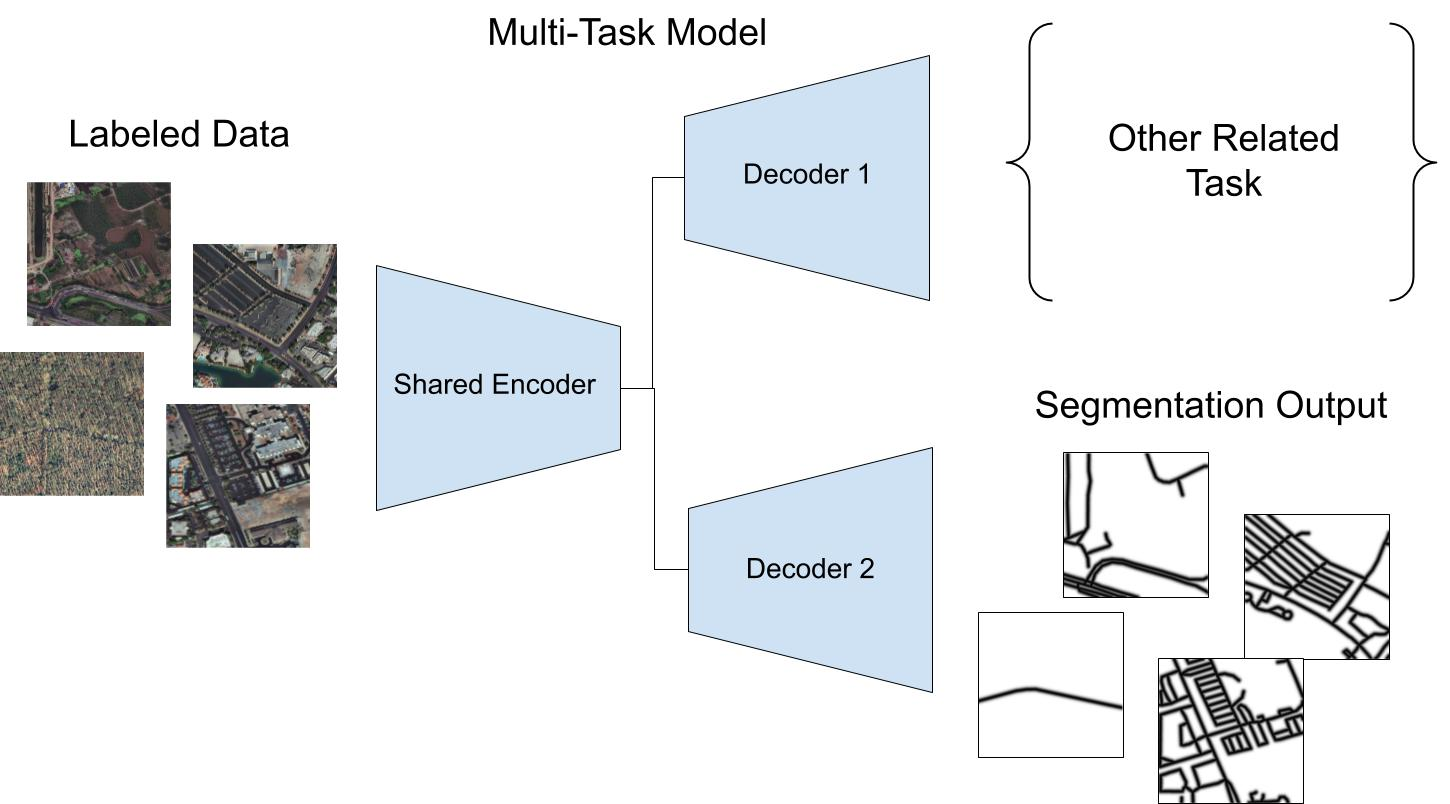</center>
<center>Figure 1. Common Multi-Task Learning framework or architecture with single encoder and multiple decoders.</center>

#### Multiple Tasks in Road Extraction

Humans perform two related tasks while annotating the roads i.e. identify the road pixels and trace lines to connect them. These two tasks are used in multi-task learning framework to improve the road extraction.

- **Binary Semantic Segmentation**: identify road pixels
- **Road Orientation**: identify the road orientation for tracing

<center>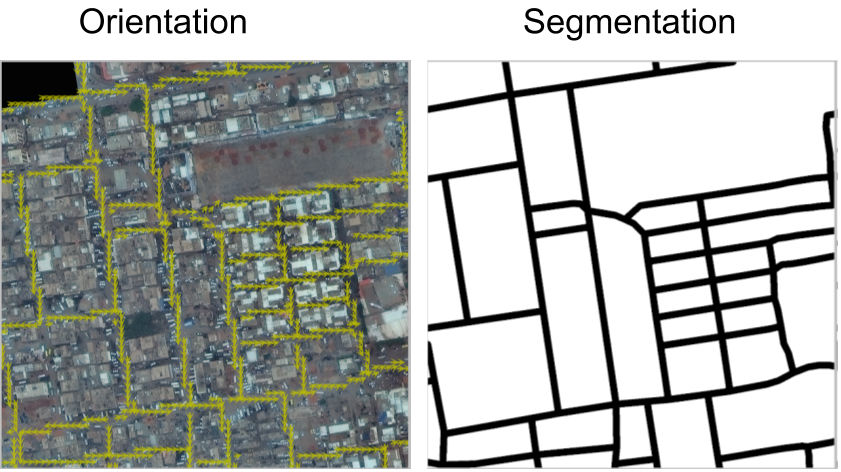</center>
<center>Figure 2. Multiple Tasks in road extraction.</center>
<!--<img src="../../static/img/mtl_road_tasks.png" height="700" width="700">-->

### How Joint learning of Road Segmenation and Orientation improves the road connectivity?

Road network extraction formulated as binary segmentation fails to produce topologically correct road map due to change in road appearance. As the annotators trace lines, highlighted nodes in (Fig. 3(a), along the center of roads with a traversable shortest path (a, c, d, e, b) for a road route *a → b*. The fragmented road network estimated using binary segmentation algorithms such as PSPNet, UNet which results in path (a, c, f, g, h, b) for the route *a → b*, which is not the shortest route. The  of annotators use additional knowledge for *orientation* for tracing roads to achieve the connectivity. Incorporating this in MTL framework, we extract connected and topologically correct road networks using segmentation and orientation.

<!--<center><img src="../../static/img/mtl_road_extractor_motivation.png" height="400" width="400"></center>-->
<center>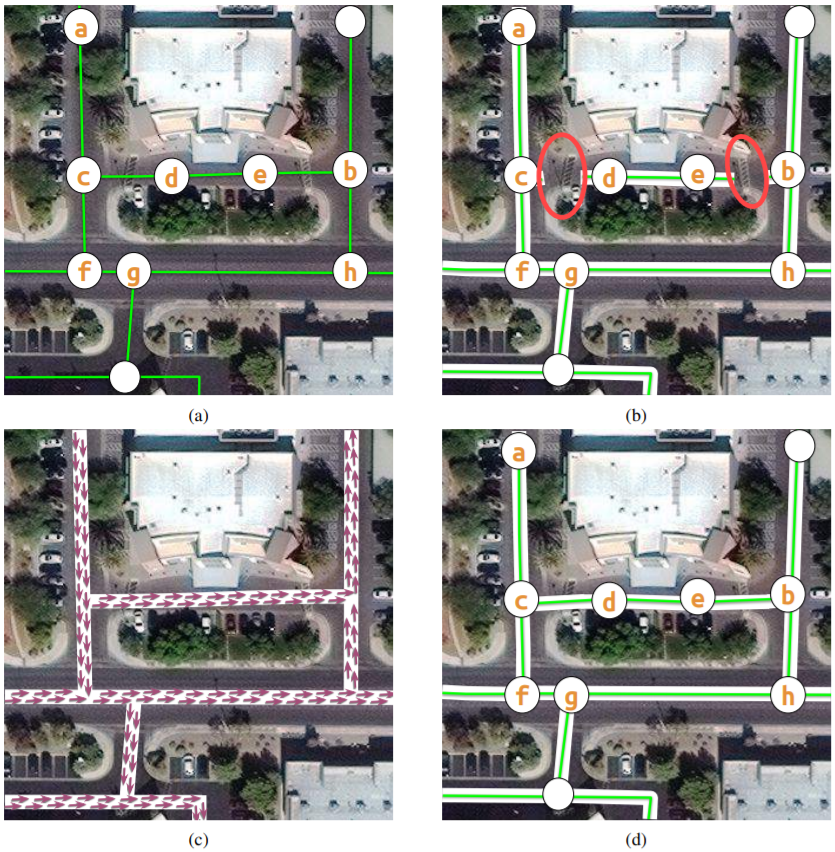</center>
<center>Figure 3. How knowledge of orientation improves road segmentation.</center>
<br/>

*Note*: For more detailed information about creating the orienatation labels, please refer section 3.1 in [1]

### Multi-Task Architectures

The stacked multi-branch module as shown, in Figure 4 is composed of three blocks:
- *Shared encoder*, 
- *Stacking and Fusion*: iterative fusion of intermediate segmentation and orientation predictions with multi-branch, and
- *Prediction Heads*: individual branches for orientation and segmentation

<!-- <center><img src="../../static/img/architecture_n_stack.jpg" height="1000" width="1000"></center> -->
<center>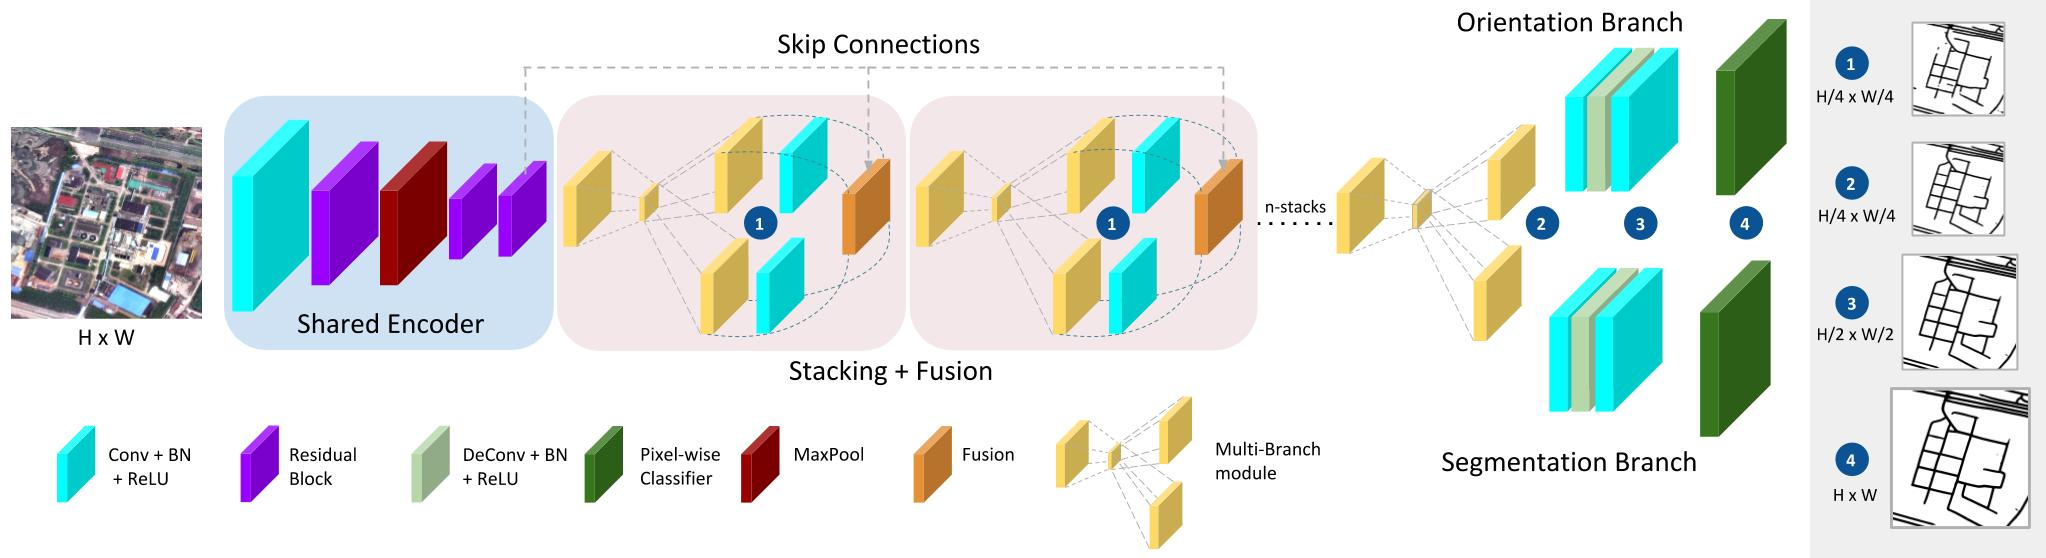</center>
<center>Figure 4. Stacked Encoder-Decoder architecture for MTL Road Extraction System.</center>
<br/>

- Apart from multi-task prediictions, the additional feature of the architecture is fusion of intermediate predictions at smaller scale. The intition behind the fusion is to allow the flow of information between both tasks to improve the performance of individual task in a multi-task learning framework. More experimental details can be found in [1]. 
-  The motivation for n-stack multi-branch module is three fold: (a) large receptive field to capture the spatial context, (b) mini encoder-decoder structure learns to recalibrate features and coarse predictions in a repetitive fashion.

### Implementation in `arcgis.learn`

`arcgis.learn` allows us to define a multi-task road extractor with two architectures with following line of code:

    mtl_road_extractor = arcgis.learn.MultiTaskRoadExtractor(data, mtl_model="hourglass", pretrained_path=None)

`data` is the returned data object from prepare_data function, `pretrained_path` points to where pre-trained model is saved and `mtl_model` defines the basic type of architecture i.e. `linknet` [3] and `hourglass` (as shown in Figure 4). To create a special data with multi-labels i.e. binary road mask and road orientation the following code is required.

    data = prepare_data(
        data_path, batch_size=16, val_split_pct=0.3,
        sub_dataset_type="RoadOrientation",
    )

The special parameter `sub_dataset_type` will create the road orientation for road extraction pipeline.

For more information about the API, please go to the [API reference](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.learn.html#unetclassifier).

### References

[1] Anil Batra, Suriya Singh, Guan Pang, Saikat Basu, C.V. Jawahar and Manohar Paluri. CVPR, 2019. [url]( https://openaccess.thecvf.com/content_CVPR_2019/papers/Batra_Improved_Road_Connectivity_by_Joint_Learning_of_Orientation_and_Segmentation_CVPR_2019_paper.pdf)

[2] Richard A. Caruna. Multitask learning: A knowledge-based source of inductive bias. In ICML, 1993. [url](http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.57.3196)

[3] Abhishek Chaurasia and Eugenio Culurciello. Linknet: Exploiting encoder representations for efficient semantic segmentation. In VCIP, 2017. [url](https://arxiv.org/pdf/1707.03718.pdf])